In [1]:
%matplotlib inline
from IPython.display import clear_output
import time
from Environments.environments import all_envs, get_all_avail_envs
from Agents.dqn_agent import DQN_Agent
from Agents.ppo_agent import PPO_Agent
from Models import fc, rnn
import matplotlib.pyplot as plt
import torch
import utils
from Curriculum_managers.random_curriculum import Random_Curriculum
from Curriculum_managers.paired_curriculum import PAIRED_Curriculum
from Curriculum_managers.paired_curriculum_no_regret_teacher_entropy import PAIRED_Curriculum_no_regret_entropy
from Curriculum_managers.paired_curriculum_no_regulator import Curriculum_Entropy_Only
import plotly.express as px
import numpy as np

In [2]:
def plot_res(vec, title):
    fig = px.line(x=range(len(np.convolve(vec, np.ones(100)/100,mode='valid'))), y=np.convolve(vec, np.ones(100)/100, mode='valid'), title=title)
    fig.show()

In [3]:
device = utils.init_torch()
env_names = get_all_avail_envs()
print(env_names[:8])

['SingleTaxiEnv', 'FrozenLakeEnv', 'AdversarialEnv', 'ReparameterizedAdversarialEnv', 'MiniAdversarialEnv', 'MiniReparameterizedAdversarialEnv', 'NoisyAdversarialEnv', 'MediumAdversarialEnv']


In [4]:
env = all_envs['MiniAdversarialEnv'](random_reset_loc=False)
n_actions = env.action_space.n
obs_shape = env.observation_space
gen_obs_shape = env.get_generator_observation_space()
gen_action_dim = env.get_generator_action_space().n

# RANDOM CURRICULUM

In [ ]:
r_agent = PPO_Agent(obs_shape, n_actions, device=device, batch_size=64, max_mem_size=10**5,num_parallel_envs=4, lr=0.0001, model=rnn.RNN)
# r_agent = DQN_Agent(obs_shape, n_actions, device=device, batch_size=64, max_mem_size=10**5, exploration_epsilon=0.3, eps_dec=0, lr=0.001, model=rnn.RNN)
r_teacher = Random_Curriculum(env ,trainee=r_agent)
r_rewards = r_teacher.teach(n_iters=30000, n_episodes=1)

loading metadatafrom ./results/Random_Curriculum/MiniAdversarialEnv/meta_data.pkl
loading models from last iter: 212


# PAIRED CURRICULUM

In [ ]:
p_agent = PPO_Agent(obs_shape, n_actions, device=device, batch_size=64, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)
teacher_agent = PPO_Agent(gen_obs_shape, n_actions, device=device, batch_size=64, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)
p_teacher = PAIRED_Curriculum(env, teacher_agent=teacher_agent ,trainee=p_agent)
p_rewards = p_teacher.teach(n_iters=30000, n_episodes=1)

loading metadatafrom ./results/PAIRED_Curriculum/MiniAdversarialEnv/meta_data.pkl
loading models from last iter: 113


# PAIRED NO REGRET NO ENT

In [ ]:
pen_agent = PPO_Agent(obs_shape, n_actions, device=device, batch_size=64, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)
pen_teacher_agent = PPO_Agent(gen_obs_shape, n_actions, device=device, batch_size=64, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)
pen_teacher = PAIRED_Curriculum_no_regret_entropy(env, teacher_agent=pen_teacher_agent ,trainee=pen_agent)
pen_rewards = pen_teacher.teach(n_iters=30000, n_episodes=1)

# ENTROPY ONLY

In [ ]:
pee_agent = PPO_Agent(obs_shape, n_actions, device=device, batch_size=64, max_mem_size=10**5, lr=0.0001, model=rnn.RNN)
pee_teacher_agent = PPO_Agent(gen_obs_shape, n_actions, device=device, batch_size=64, max_mem_size=10**5 ,lr=0.0001, model=rnn.RNN)
pee_teacher = Curriculum_Entropy_Only(env, teacher_agent=pee_teacher_agent ,trainee=pee_agent)
pee_rewards = pee_teacher.teach(n_iters=30000, n_episodes=1)

In [16]:
plot_res(pee_teacher.agent_train_entropy, "trainee_entropy")

In [ ]:
env = pee_teacher.create_envs(1)[0]
plt.imshow(env.render('rgb_array'))

# RESULTS CHECK

In [43]:
env = pee_teacher.create_envs(1)[0]

In [ ]:
env.reset_random()
plt.imshow(env.render('rgb_array'))

In [ ]:
#pen_agent, p_agent, r_agent, #r_agent2

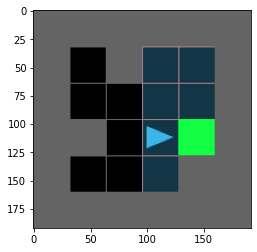

2 0.964 True
evaluation episode: 0 R: 0.964


In [60]:
agent = pee_agent
agent.set_eval_mode()

for i in range(1):
    obs = env.reset()
    # break
    R = 0
    t = 0
    while True:
        # Uncomment to watch the behavior in a GUI window
        clear_output(wait=True)
        plt.imshow(env.render('rgb_array'))
        plt.show()
        # env.render(mode='rgb_array')
        # env.render()
        action = agent.act(obs)
        obs, r, done, _ = env.step(action)
        print(action, r, done)

        R += r
        t += 1
        reset = t == 500
        time.sleep(0.1)

        if done or reset:
            break
    print('evaluation episode:', i, 'R:', R)

# FOR DEBUG

In [ ]:
o=env.reset()
agent = pee_agent
agent.reset_rnn_hidden()
# o = env.reset()
v= agent.pre_process_obs_for_act(o,1)
agent.critic_model(v)

o,_,_,_ = env.step(2)
plt.imshow(env.render('rgb_array'))